In [114]:
import tensorflow as tf
from tensorflow.keras import layers
import os
import numpy as np
import time
import matplotlib.pyplot as plt
import cv2
from tensorflow.keras.optimizers import Adam
from IPython import display
# from google.colab import drive
import pickle
import PIL
from IPython import display
import imageio
import glob

# Prepare the dataset
### 15747 images (64,64,3)



In [4]:
cat_images_dir = "../input/cats-faces-64x64-for-generative-models/cats/"

dataset = []
for each in os.listdir(cat_images_dir):
    image = cv2.imread(os.path.join(cat_images_dir, each))
    if type(image) != type(None) and "jpg" in each:
        dataset.append(image)

dataset = np.array(dataset)
print(dataset.shape)

(15747, 64, 64, 3)


In [5]:
dataset.min(), dataset.max()

(0, 255)

In [6]:
dataset.shape

(15747, 64, 64, 3)

In [7]:
dataset = (dataset - 127.5)/127.5    # Normalize the images to [-1, 1]
dataset.min(), dataset.max()

(-1.0, 1.0)

### Store the dataset


In [ ]:
base_path = '../working/'
file_to_store = open(base_path + "dataset.pickle", "wb")
pickle.dump(dataset, file_to_store)
file_to_store.close()

### Load the dataset

In [ ]:
base_path = '../working/'
file_to_read = open(base_path + "dataset.pickle", "rb")
dataset = pickle.load(file_to_read)
file_to_read.close()

In [13]:
# Batch and shuffle the data
BATCH_SIZE = 64
BUFFER_SIZE = 15747

train_dataset = tf.data.Dataset.from_tensor_slices(dataset).shuffle(BUFFER_SIZE).batch(BATCH_SIZE)
print(train_dataset)

<BatchDataset element_spec=TensorSpec(shape=(None, 64, 64, 3), dtype=tf.float64, name=None)>


# Create the model


## Generator 


In [14]:
def generator_model(noise_dim):
    model = tf.keras.Sequential()
    
    model.add(layers.Dense(4*4*1024, input_shape=(noise_dim,)))
    model.add(layers.Reshape((4, 4, 1024)))
    model.add(layers.LeakyReLU())
    
    model.add(layers.Conv2DTranspose(filters=512, kernel_size=(5,5), strides=(2,2), padding='same',
            kernel_initializer=tf.initializers.truncated_normal(stddev=0.02)))
    model.add(layers.BatchNormalization())
    model.add(layers.LeakyReLU())
    
    model.add(layers.Conv2DTranspose(filters=256, kernel_size=(5,5), strides=(2,2), padding='same',
             kernel_initializer=tf.initializers.truncated_normal(stddev=0.02)))
    model.add(layers.BatchNormalization())
    model.add(layers.LeakyReLU())
    
    model.add(layers.Conv2DTranspose(filters=128, kernel_size=(5,5), strides=(2,2), padding='same',
             kernel_initializer=tf.initializers.truncated_normal(stddev=0.02)))
    model.add(layers.BatchNormalization())
    model.add(layers.LeakyReLU())
    

    model.add(layers.Conv2DTranspose(filters=64, kernel_size=(5,5), strides=(2,2), padding='same',
             kernel_initializer=tf.initializers.truncated_normal(stddev=0.02)))
    model.add(layers.BatchNormalization())
    model.add(layers.LeakyReLU())
    
    model.add(layers.Conv2DTranspose(filters=3, kernel_size=(5,5), strides=(1,1), padding='same',
             kernel_initializer=tf.initializers.truncated_normal(stddev=0.02),
             activation='tanh'))
    # output (64,64,3)

    return model

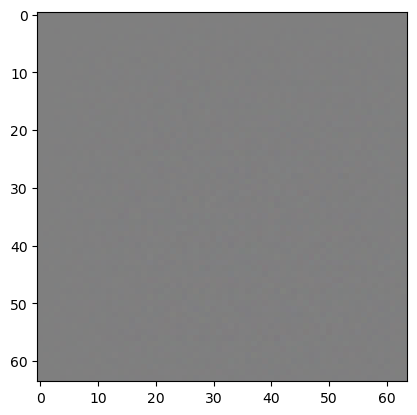

In [136]:
# Test
noise_dim = 100
generator = generator_model(noise_dim)
noise = tf.random.normal([1, noise_dim])
generated_image = generator(noise, training=False)
plt.imshow((generated_image[0, :, :, :] * 0.5) + 0.5)

## Discriminator

In [16]:
def make_discriminator_model():
    model = tf.keras.Sequential()
    
    model.add(layers.Conv2D(filters=64, kernel_size=(5,5), strides=(2,2), padding='same', input_shape=(64, 64, 3)))
    model.add(layers.BatchNormalization(epsilon = 1e-5))
    model.add(layers.LeakyReLU())

    model.add(layers.Conv2D(filters=128, kernel_size=(5,5), strides=(2,2), padding='same'))
    model.add(layers.BatchNormalization(epsilon = 1e-5))
    model.add(layers.LeakyReLU())
    
    model.add(layers.Conv2D(filters=256, kernel_size=(5,5), strides=(2,2), padding='same'))
    model.add(layers.BatchNormalization(epsilon = 1e-5))
    model.add(layers.LeakyReLU())
    
    model.add(layers.Conv2D(filters=512, kernel_size=(5,5), strides=(1,1), padding='same'))
    model.add(layers.BatchNormalization(epsilon = 1e-5))
    model.add(layers.LeakyReLU())
    
    model.add(layers.Conv2D(filters=1024, kernel_size=(5,5), strides=(2,2), padding='same'))
    model.add(layers.BatchNormalization(epsilon = 1e-5))
    model.add(layers.LeakyReLU())
    
    model.add(layers.Flatten())
    model.add(layers.Dense(1, activation='sigmoid'))
    
    return model

In [21]:
# Test

discriminator = make_discriminator_model()
decision = discriminator(generated_image)
print(decision)

tf.Tensor([[0.50000614]], shape=(1, 1), dtype=float32)


## Model Loss

In [22]:
cross_entropy = tf.keras.losses.BinaryCrossentropy(from_logits=True)

In [23]:
def generator_loss(fake_output):
    return cross_entropy(tf.ones_like(fake_output), fake_output)

In [24]:
def discriminator_loss(real_output, fake_output):
    real_loss = cross_entropy(tf.ones_like(real_output), real_output)
    fake_loss = cross_entropy(tf.zeros_like(fake_output), fake_output)
    total_loss = real_loss + fake_loss
    return total_loss

In [25]:
generator_optimizer = Adam(1e-4)
discriminator_optimizer = Adam(1e-4)

### Save Checkpoints

In [27]:
checkpoint_dir = '../working/training_checkpoints/'
checkpoint_prefix = os.path.join(checkpoint_dir, "ckpt")
checkpoint = tf.train.Checkpoint(generator_optimizer=generator_optimizer,
                                 discriminator_optimizer=discriminator_optimizer,
                                 generator=generator,
                                 discriminator=discriminator)

# Train the model

In [28]:
EPOCHS = 210
noise_dim = 100
num_examples_to_generate = 16

# You will reuse this seed overtime (so it's easier)
# to visualize progress in the animated GIF)
seed = tf.random.normal([num_examples_to_generate, noise_dim])

In [29]:
# Notice the use of `tf.function`
# This annotation causes the function to be "compiled".
@tf.function
def train_step(images):
    noise = tf.random.normal([BATCH_SIZE, noise_dim])
    
    with tf.GradientTape() as gen_tape, tf.GradientTape() as disc_tape:
        generated_images = generator(noise, training=True)

        real_output = discriminator(images, training=True)
        fake_output = discriminator(generated_images, training=True)

        gen_loss = generator_loss(fake_output)
        disc_loss = discriminator_loss(real_output, fake_output)

    gradients_of_generator = gen_tape.gradient(gen_loss, generator.trainable_variables)
    gradients_of_discriminator = disc_tape.gradient(disc_loss, discriminator.trainable_variables)

    generator_optimizer.apply_gradients(zip(gradients_of_generator, generator.trainable_variables))
    discriminator_optimizer.apply_gradients(zip(gradients_of_discriminator, discriminator.trainable_variables))

### Generate and save images

In [30]:
def generate_and_save_images(model, epoch, test_input):
    predictions = model(test_input, training=False)

    fig = plt.figure(figsize=(8, 8))

    for i in range(predictions.shape[0]):
        plt.subplot(4, 4, i+1)
        plt.imshow(predictions[i, :, :] * 0.5 + 0.5)
        plt.axis('off')
    path = '../working/sc/'
    plt.savefig(path + 'image_at_epoch_{:04d}.png'.format(epoch))
    plt.show()

In [31]:
def train(dataset, epochs):
    for epoch in range(epochs):
        start = time.time()
        
        print(f"Batch size: {BATCH_SIZE}")
        batch = 0
        for image_batch in dataset:
            batch += 1
            print(f"batch: {batch}")
            train_step(image_batch)
            
        # Produce images for the GIF as you go
        display.clear_output(wait=True)
        generate_and_save_images(generator,
                             epoch + 1,
                             seed)
        
        # Save the model every 10 epochs
        if (epoch + 1) % 10 == 0:
            checkpoint.save(file_prefix = checkpoint_prefix)

        print ('Time for epoch {} is {} sec'.format(epoch + 1, time.time()-start))
        
    # Generate after the final epoch
    display.clear_output(wait=True)
    generate_and_save_images(generator,
                           epochs,
                           seed)

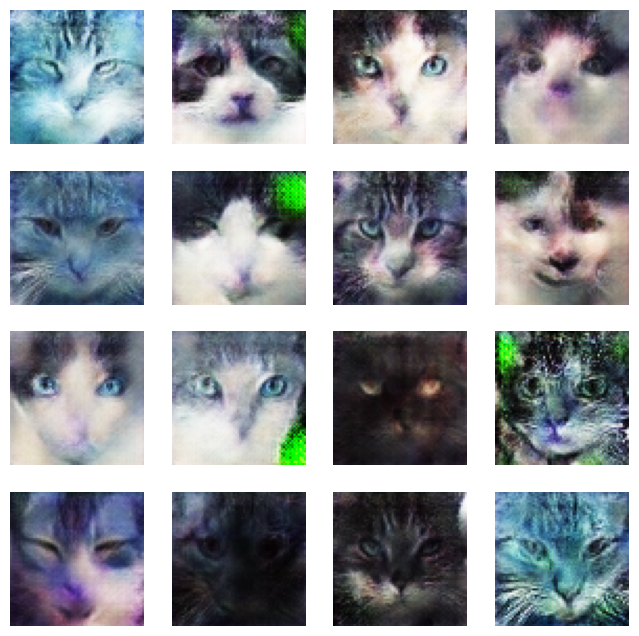

In [32]:
train(train_dataset, EPOCHS)

In [ ]:
checkpoint.restore(tf.train.latest_checkpoint(checkpoint_dir))
restored_generator = checkpoint.generator
restored_discriminator = checkpoint.discriminator

print(restored_generator)
print(restored_discriminator)

### Test the model

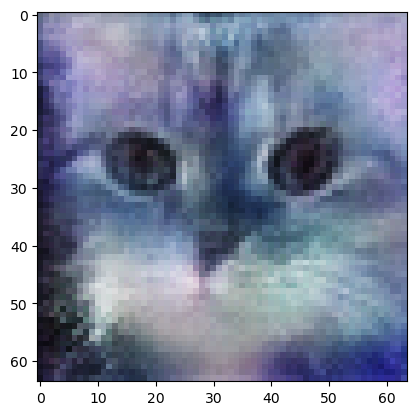

In [84]:
noise_dim = 100
noise = tf.random.normal([1, noise_dim])
generated_image = restored_generator(noise, training=False)
plt.imshow((generated_image[0, :, :, :] * 0.5) + 0.5)

In [85]:
decision = restored_discriminator(generated_image)
print(decision)   # (fake) 0 ...... 1 (real)

tf.Tensor([[0.9940935]], shape=(1, 1), dtype=float32)


### Create a GIF

In [101]:
# Display a single image using the epoch number
def display_image(epoch_no):
    base_path = '../working/sc/'
    return PIL.Image.open(base_path + 'image_at_epoch_{:04d}.png'.format(epoch_no))

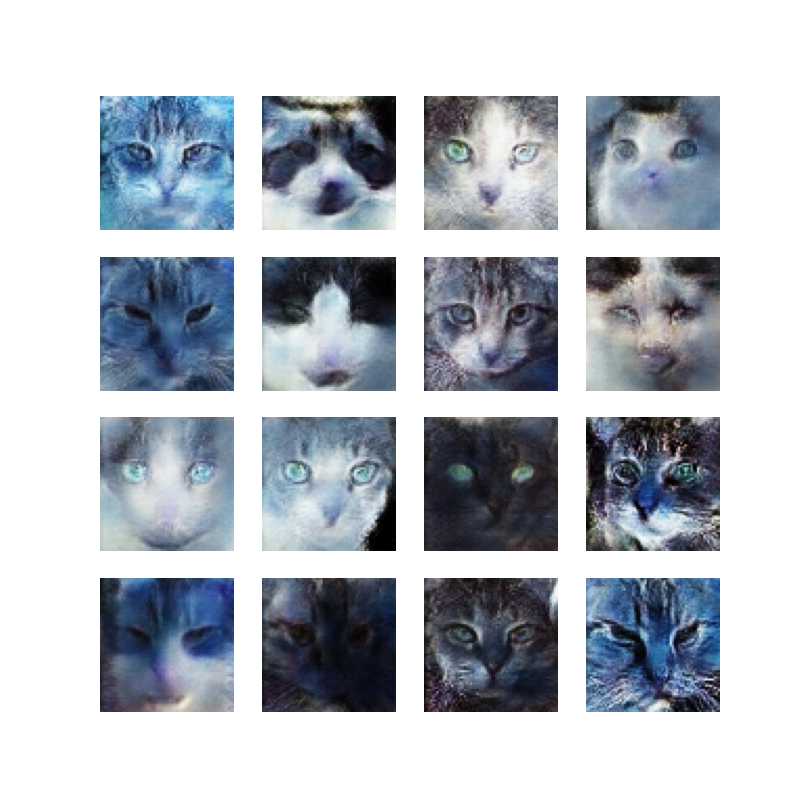

In [110]:
display_image(205)

In [124]:
anim_file = 'dcgan.gif'

with imageio.get_writer(anim_file, mode='I') as writer:
    base_path = '../working/sc/'
    filenames = glob.glob(base_path + 'image*.png')
    filenames = sorted(filenames)
    n = 0
    for filename in filenames:
        if n % 10 == 0:
            image = imageio.imread(filename)
            writer.append_data(image)
        n += 1
    image = imageio.imread(filename)
    writer.append_data(image)

/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:10: DeprecationWarning: Starting with ImageIO v3 the behavior of this function will switch to that of iio.v3.imread. To keep the current behavior (and make this warning disappear) use `import imageio.v2 as imageio` or call `imageio.v2.imread` directly.
  # Remove the CWD from sys.path while we load stuff.
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:13: DeprecationWarning: Starting with ImageIO v3 the behavior of this function will switch to that of iio.v3.imread. To keep the current behavior (and make this warning disappear) use `import imageio.v2 as imageio` or call `imageio.v2.imread` directly.
  del sys.path[0]



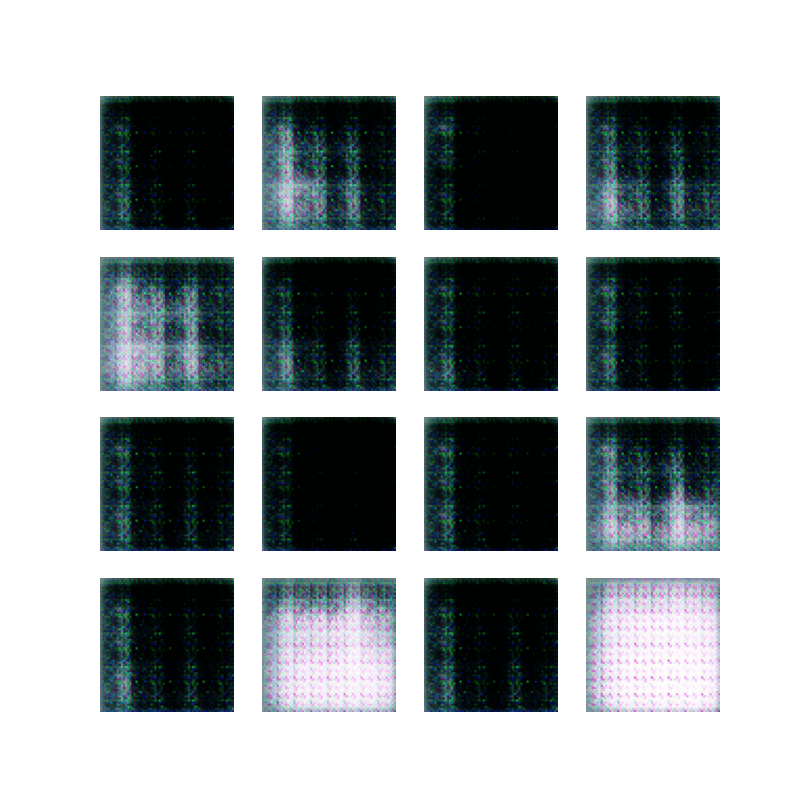

In [125]:
import tensorflow_docs.vis.embed as embed
embed.embed_file(anim_file)